In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import interpolate
import scipy
from scipy import ndimage
from scipy.optimize import curve_fit

In [3]:
ASCIIFILE = 'GPTrelated/outscope.txt'
# ASCIIFILE = 'outscope.txt'
MConHBAR  =  2.59e12
maxsig = 1  # determine how many standard deviations are we going to plot

## Directly calculate emittance from defination

In [15]:
# Try new way to directly calculate emittance based on defination in unit of [pm*rad]
screen =  np.loadtxt(ASCIIFILE, skiprows=5)

x  = screen[:,0]
y  = screen[:,1]
rxy = screen[:,3]
x = x * 1e12
y = y * 1e12  # x and y in unit of pm
rxy = rxy * 1e12
# index = np.where(rxy<15000)

ax = np.divide(screen[:,4], screen[:,6])
ay = np.divide(screen[:,5], screen[:,6])
arx = np.sqrt(ax**2 + ay**2)
index = np.where(arx < 0.04)

x = x[index]
y = y[index]
ax = ax[index]
ay = ay[index]

emit_1 = np.average(x**2 + y**2) # first term in pm^2
emit_2 = np.average(ax**2 + ay**2) # second term in rad^2
emit_3 = np.average(x*ax + y*ay) # third term in (pm*rad)^2
emit = np.sqrt(emit_1 * emit_2 - emit_3**2) # emittance in unit of [pm*rad]

print(emit)
print(emit_1, emit_2, emit_3)
print(emit_1*emit_2, emit_3)

28.255099543527013
1260957.9524320182 0.0006811237765968312 7.779318252628781
858.8684426903037 7.779318252628781


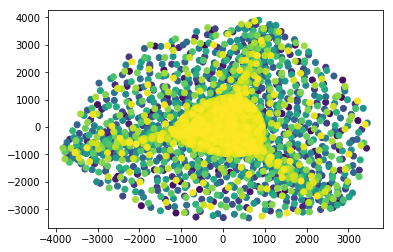

In [16]:
plt.scatter(x,y, c=np.linspace(0,1,len(x)))

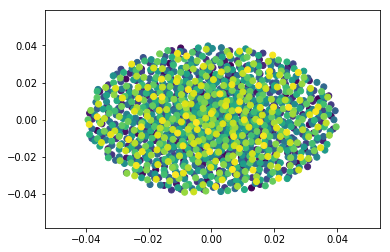

In [6]:
plt.scatter(ax,ay,c=np.linspace(0,1,len(x)))

12886


Text(0, 0.5, '|x| ($\\mu$m)')

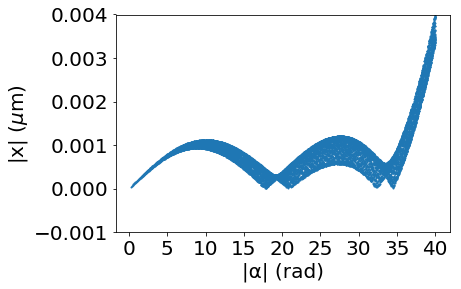

In [17]:
# show the artifact when H1 and H2 are off

screen =  np.loadtxt('GPTrelated/outscope.txt', skiprows=5)
x  = screen[:,0]
y  = screen[:,1]
rxy = screen[:,3]
kx = np.divide(screen[:,4], screen[:,6])
ky = np.divide(screen[:,5], screen[:,6])
kxy = np.sqrt(kx**2 + ky**2)
index = np.where(np.abs(kxy)<0.040)
print(len(index[0]))

plt.scatter(np.asarray(kxy[index])*1000,np.asarray(rxy[index])*1e6, s=1)
plt.ylim([-0.001,np.amax(rxy[index])*1e6])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('|\u03B1| (rad)', fontsize = 20)
plt.ylabel('|x| ($\mu$m)', fontsize = 20)

In [18]:
FILENAME = "GPTrelated/trnsmssn_new.pickle"
sampleL = 2.096e-9*4
sampleScale = 1
maxsig = 1.0
screen =  np.loadtxt(ASCIIFILE, skiprows=5)

x  = screen[:,0]
y  = screen[:,1]
kx = np.divide(screen[:,4], screen[:,6])
ky = np.divide(screen[:,5], screen[:,6])

# Crop the simulation particles in phase space
# arx = np.sqrt(kx**2 + ky**2)
# index = np.where(arx < 0.04)

# x = x[index]
# y = y[index]
# kx = kx[index]
# ky = ky[index]

# Crop the simulated particles in real space using rxy
# necessary to crop at rxy < 70000 pm for uncorrected state

rxy = screen[:,3]
index = np.where(rxy<70000/1e12)
kxy = np.sqrt(kx**2 + ky**2)

x = x[index]
y = y[index]
kx = kx[index]
ky = ky[index]

meankx = np.mean(kx)
sigkx  = np.std(kx)

meanky = np.mean(ky)
sigky  = np.std(ky)

N = 100
meankx = 0
meanky = 0
sigkx = .040/maxsig
sigky = .040/maxsig

x_bins = [[[] for n in range(0,N)] for m in range(0,N)]
y_bins = [[[] for n in range(0,N)] for m in range(0,N)]

x_grid = np.zeros([N, N])
y_grid = np.zeros([N, N])

kx_grid, ky_grid = np.meshgrid(sigkx*np.linspace(-maxsig, maxsig, N),
                             sigky*np.linspace(-maxsig, maxsig, N))

for xi, yi, kxi, kyi in zip(x, y, kx, ky):
    i = int(0.5*N*((kyi-meanky)/(maxsig*sigky)) + 0.5*N)
    j = int(0.5*N*((kxi-meankx)/(maxsig*sigkx)) + 0.5*N)
    if i < 0 or i > N-1 or j < 0 or j > N-1:
        continue
    x_bins[i][j].append(xi)
    y_bins[i][j].append(yi)

for i in range(0, N):
    for j in range(0, N):
        x_grid[i,j] = np.mean(x_bins[i][j])
        y_grid[i,j] = np.mean(y_bins[i][j])
        
y_grid[np.isnan(y_grid)]=0
x_grid[np.isnan(x_grid)]=0

index = np.where(x_grid != 0)

xfunc = interpolate.SmoothBivariateSpline(kx_grid[index].flatten(), ky_grid[index].flatten(), 
                                          x_grid[index].flatten(), kx=5, ky=5)
yfunc = interpolate.SmoothBivariateSpline(kx_grid[index].flatten(), ky_grid[index].flatten(), 
                                          y_grid[index].flatten(), kx=5, ky=5)
# # Previous fitting method
# xfunc = interpolate.SmoothBivariateSpline(kx_grid.flatten(), ky_grid.flatten(), 
#                                           x_grid.flatten(), kx=3, ky=3)
# yfunc = interpolate.SmoothBivariateSpline(kx_grid.flatten(), ky_grid.flatten(), 
#                                           y_grid.flatten(), kx=3, ky=3)

ky_fine = np.linspace(-sigkx*maxsig, sigkx*maxsig, 401)
kx_fine = np.linspace(-sigkx*maxsig, sigkx*maxsig, 401)

with open(FILENAME, "rb") as f:
    trnsmssn = pickle.load(f)
print(sigkx)  # print the number of sigkx, in unit of rad, which is the limit on the Ronchigram

shadow = np.array([[trnsmssn((xfunc(kx, ky)[0][0]/sampleScale + sampleL/2)%sampleL, 
                             (yfunc(kx, ky)[0][0]/sampleScale + sampleL/2)%sampleL)[0] for kx in kx_fine] for ky in ky_fine])

0.04


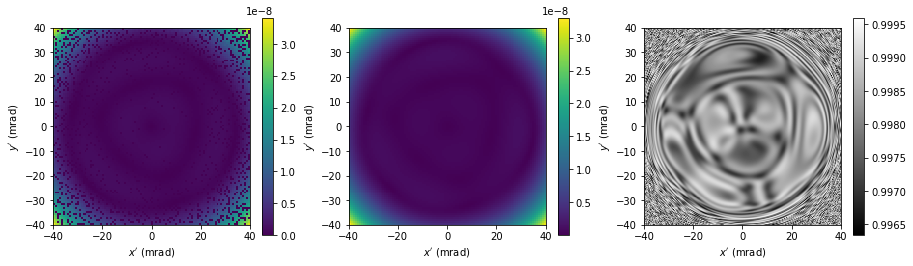

In [19]:
# maxsig = 1.0, extend to 8 mrad
fig = plt.figure(figsize=[15,4])

plt.subplot(131)
temp = np.sqrt(x_grid**2+y_grid**2)
plt.imshow(temp,extent = [-sigkx*maxsig*1000,sigkx*maxsig*1000,-sigky*maxsig*1000,sigky*maxsig*1000])
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$")
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$")
plt.colorbar()

temp_interpolate = np.zeros([N,N])
for kx in range(N):
    for ky in range(N):
        x = xfunc(kx_grid[kx,ky], ky_grid[kx,ky])
        y = yfunc(kx_grid[kx,ky], ky_grid[kx,ky])
        temp_interpolate[kx,ky] = np.sqrt(x**2 + y**2)

plt.subplot(132)
plt.imshow(temp_interpolate,extent = [-sigkx*maxsig*1000,sigkx*maxsig*1000,-sigky*maxsig*1000,sigky*maxsig*1000])
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$")
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$")
plt.colorbar()

plt.subplot(133)
plt.imshow(shadow,cmap='gray', extent = [-sigkx*maxsig*1000,sigkx*maxsig*1000,-sigky*maxsig*1000,sigky*maxsig*1000])
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$")
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$")
plt.colorbar()

Text(0, 0.5, 'x ($\\mu$m)')

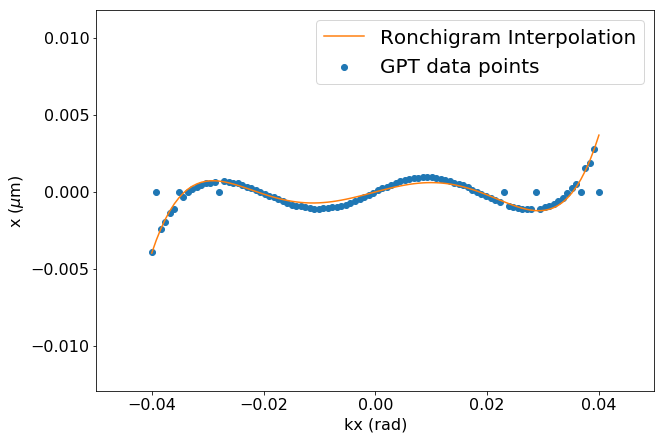

In [20]:
fig = plt.figure(figsize=[10,7])

temp = np.sqrt(x_grid**2+y_grid**2)
center = int(x_grid.shape[0]/2)

plt.scatter(kx_grid[center,:], x_grid[center,:]*1e6, label='GPT data points')
plt.plot(kx_grid[center,:], xfunc(kx_grid[center,:],0)*1e6,label = 'Ronchigram Interpolation', c='C1')

plt.legend(fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('kx (rad)', fontsize = 16)
plt.ylabel('x ($\mu$m)', fontsize = 16)

Polynominal fit without constrain:
[-2.66106212e-01  4.71806489e-02 -2.28979117e-03  4.18906460e-05
 -2.84684031e-07  1.27184333e-09]
0th order term fixed at zero
[-2.17357611e-01  3.80630706e-02 -1.65639441e-03  2.19090417e-05
 -7.99876425e-09]


Text(0, 0.5, '|x| ($\\mu$m)')

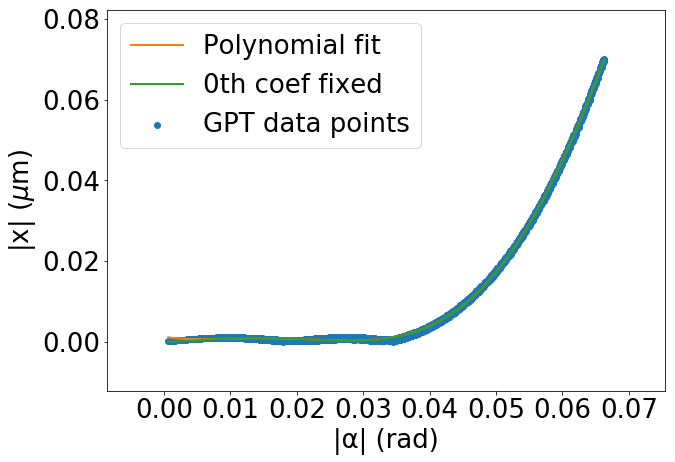

In [12]:
# Directly fit aberration coefficients from rxy, kxy output of GPT

def func5(x, a, b, c, d, e):
  return e*x + d*x**2 + c*x**3 + b*x**4 + a*x**5

def func3(x, a, b, c):
  return c*x + b*x**2 + a*x**3

screen =  np.loadtxt(ASCIIFILE, skiprows=5)

x  = screen[:,0]
y  = screen[:,1]
rxy = screen[:,3]

ax = np.divide(screen[:,4], screen[:,6])
ay = np.divide(screen[:,5], screen[:,6])
kxy = np.sqrt(ax**2 + ay**2)

index = np.where(rxy<70000/1e12)
# index = np.where(kxy<0.04)
x = np.asarray(kxy[index])
y = np.asarray(rxy[index])

fig = plt.figure(figsize=[10,7])
plt.scatter(x, y*1e6, label='GPT data points')

# default np.polyfit without constrain on each coefficient
z = np.polyfit(x, y, 5)
# z = np.polyfit(x, y, 3)
p3 = np.poly1d(z)
print('Polynominal fit without constrain:')
print(z)
# use sorted x to get a good plot
plt.plot(np.sort(x), p3(np.sort(x))*1e6, c='C1', label='Polynomial fit', linewidth = 2)

# customized curve_fit with 0th order term fix at zero
popt_cons, _ = curve_fit(func5, x, y, bounds=([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf], 
                                             [np.inf, np.inf, np.inf, np.inf, np.inf]))

# fit up to 3rd order
# popt_cons, _ = curve_fit(func3, x, y, bounds=([-np.inf, -np.inf, -np.inf], 
#                                              [np.inf, np.inf, np.inf]))

print('0th order term fixed at zero')
print(popt_cons)

plt.plot(np.sort(x), func5(np.sort(x), *popt_cons)*1e6, c='C2', label='0th coef fixed', linewidth = 2)
plt.legend(fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.xlabel('|\u03B1| (rad)', fontsize = 26)
plt.ylabel('|x| ($\mu$m)', fontsize = 26)

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 <a list of 9 Text yticklabel objects>)

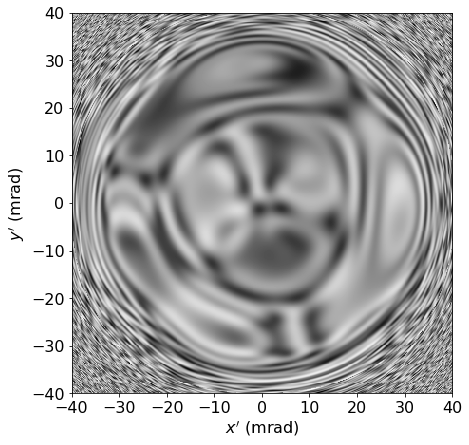

In [21]:
fig = plt.figure(figsize=[7,7])
plt.subplot(111)
plt.imshow(shadow,cmap='gray', extent = [-sigkx*maxsig*1000,sigkx*maxsig*1000,-sigky*maxsig*1000,sigky*maxsig*1000])

plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$", fontsize=16)
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.axis('off')

## Check the artifact caused by interpolation
GPT relies on the relationship between (x,y) and (kx,ky) to simulate Ronchigram.
GPT simulated electrons only cover a fraction of the k space, and is often in a ring, the rest would be calculated using interpolation.

Text(0, 0.5, '$y^\\prime \\ \\mathrm{(mrad)}$')

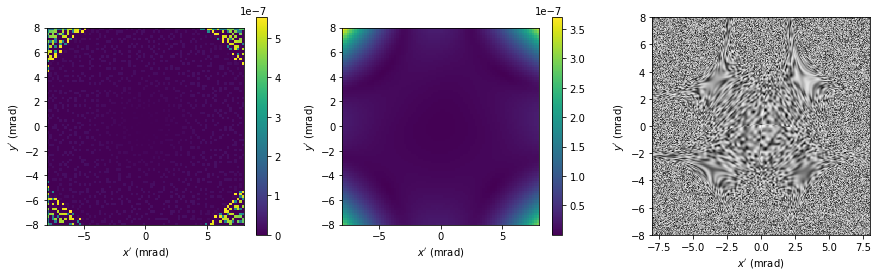

In [154]:
# maxsig = 1.0, extend to 8 mrad
fig = plt.figure(figsize=[15,4])

plt.subplot(131)
temp = np.sqrt(x_grid**2+y_grid**2)
# plt.plot(temp[40,:])
plt.imshow(temp,extent = [-sigkx*maxsig*1000,sigkx*maxsig*1000,-sigky*maxsig*1000,sigky*maxsig*1000])
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$")
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$")
plt.colorbar()

temp_interpolate = np.zeros([N,N])
for kx in range(N):
    for ky in range(N):
        x = xfunc(kx_grid[kx,ky], ky_grid[kx,ky])
        y = yfunc(kx_grid[kx,ky], ky_grid[kx,ky])
        temp_interpolate[kx,ky] = np.sqrt(x**2 + y**2)

plt.subplot(132)
plt.imshow(temp_interpolate,extent = [-sigkx*maxsig*1000,sigkx*maxsig*1000,-sigky*maxsig*1000,sigky*maxsig*1000])
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$")
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$")
plt.colorbar()

plt.subplot(133)
plt.imshow(shadow,cmap='gray', extent = [-sigkx*maxsig*1000,sigkx*maxsig*1000,-sigky*maxsig*1000,sigky*maxsig*1000])
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$")
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$")

[[5.78807789e-10]] [[-7.25640014e-10]]


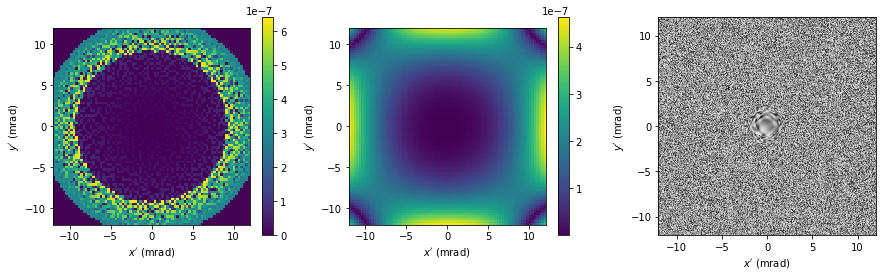

In [183]:
# maxsig = 1.5, extend to 12 mrad
fig = plt.figure(figsize=[15,4])

plt.subplot(131)
temp = np.sqrt(x_grid**2+y_grid**2)
# plt.plot(temp[40,:])
plt.imshow(temp,extent = [-sigkx*maxsig*1000,sigkx*maxsig*1000,-sigky*maxsig*1000,sigky*maxsig*1000])
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$")
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$")
plt.colorbar()

temp_interpolate = np.zeros([N,N])
for kx in range(N):
    for ky in range(N):
        x = xfunc(kx_grid[kx,ky], ky_grid[kx,ky])
        y = yfunc(kx_grid[kx,ky], ky_grid[kx,ky])
        temp_interpolate[kx,ky] = np.sqrt(x**2 + y**2)

plt.subplot(132)
plt.imshow(temp_interpolate,extent = [-sigkx*maxsig*1000,sigkx*maxsig*1000,-sigky*maxsig*1000,sigky*maxsig*1000])
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$")
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$")
plt.colorbar()

plt.subplot(133)
plt.imshow(shadow,cmap='gray', extent = [-sigkx*maxsig*1000,sigkx*maxsig*1000,-sigky*maxsig*1000,sigky*maxsig*1000])
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$")
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$")

# check what the interpolation gives with zero angle
print(xfunc(0,0),yfunc(0,0))

## Fit the relationship of x vs kx, and get Cs coefficient

[ 7.39058490e+00 -1.61789829e-03  1.31278437e-04  1.03728382e-06
  5.27675709e-09 -2.36854150e-11]


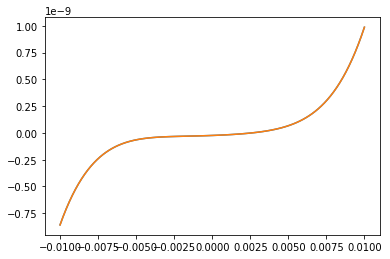

In [633]:
x = np.linspace(-0.01,0.01,num=100) # up to 12 mrad in k space
y = np.squeeze(xfunc(x,0))
z = np.polyfit(x, y, 5)
print(z)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p3 = np.poly1d(z)
plt.plot(x,y)
plt.plot(x,p3(x))

# y_diff = y - p3(x)
# plt.plot(x,y_diff)
# z = np.polyfit(x, y_diff, 3)
# p3 = np.poly1d(z)
# plt.plot(x,p3(x))
# print(z)

[2.34197095e-05 1.32006168e-09]
[ 3.09222330e-15  2.63919469e-01  1.51369916e-05 -2.32601995e-05
 -7.41253889e-10]


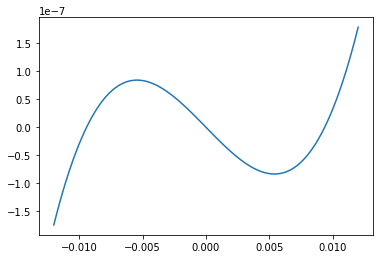

In [267]:
x = np.linspace(-0.012,0.012,num=100) # up to 12 mrad in k space
y = np.squeeze(xfunc(x,0))
z = np.polyfit(x, y, 1)
print(z)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p3 = np.poly1d(z)
# plt.plot(x,y)
# plt.plot(x,p3(x))
y_diff = y - p3(x)
plt.plot(x,y_diff)
z = np.polyfit(x, y_diff, 4)
print(z)

## Prepare transmission phase plate

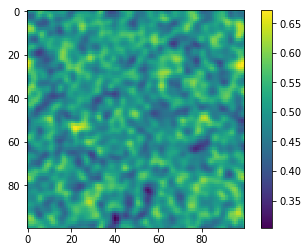

In [98]:
# Check the function Cameron used to generate trnsnssn:
kx_grid, ky_grid = np.meshgrid(np.linspace(0, 5e-10, 100), np.linspace(0, 5e-10, 100))
image = np.zeros([100,100])
for ix in range(100):
    for iy in range(100):
        image[ix,iy] = trnsmssn(kx_grid[ix, iy], ky_grid[ix, iy])[0]
plt.imshow(image)
plt.colorbar()

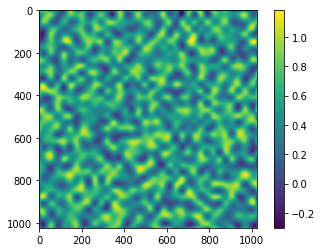

In [233]:
# try to regenerate an interpolate2D that looks similar to Noah's random array

npx = 8+1
sampleL = 2.096e-9
totalpx = 256

npx = npx*4
sampleL = sampleL*4
totalpx = totalpx * 4

# step1: generate a 8x8 fully random array
z = np.random.rand(npx, npx)

# step2: interpolate to 128x128
x = np.array(range(npx))
y = np.array(range(npx))
xx, yy = np.meshgrid(x, y)
f = interpolate.interp2d(x, y, z, kind='cubic')

xnew = np.linspace(0, npx-1, totalpx)
ynew = np.linspace(0, npx-1, totalpx)
znew = f(xnew, ynew)

# step3: Gaussian blurring
znew = scipy.ndimage.gaussian_filter(znew, 3)
plt.imshow(znew)
plt.colorbar()

# step4: generate interp2d object using the new object
x = np.linspace(0,sampleL,totalpx)
y = np.linspace(0,sampleL,totalpx)
trnsmssn = interpolate.interp2d(x,y,znew, kind='cubic')

In [234]:
wavelen = 12.3986/np.sqrt((2*511.0+300)*300) * 1e-9;
noise_fn = znew
noise_fn = noise_fn + 1;
noise_fn = noise_fn/2;
charge_e = 1.602e-19;
mass_e = 9.11e-31;
c = 3e8;
interaction_param = 2*math.pi/(wavelen*300/charge_e*1000)*(mass_e*c**2+300*1000)/(2*mass_e*c*c+300*1000);
interaction_param_0 = 1.7042e-12
trans = np.exp(-1j*math.pi/4*noise_fn*interaction_param/interaction_param_0);

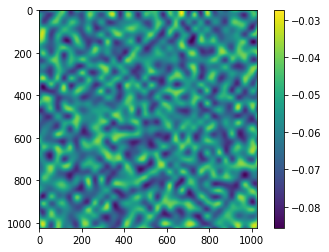

In [235]:
plt.imshow(trans.imag)
plt.colorbar()

In [236]:
x = np.linspace(0,sampleL,totalpx)
y = np.linspace(0,sampleL,totalpx)
trnsmssn = interpolate.interp2d(x,y,trans.real,kind='cubic')

In [243]:
pickle.dump( trnsmssn, open( "GPTrelated/trnsmssn_new.pickle", "wb" ) )

## Diagnose and fix the 'phase wrapping' problem when generating Ronchigram

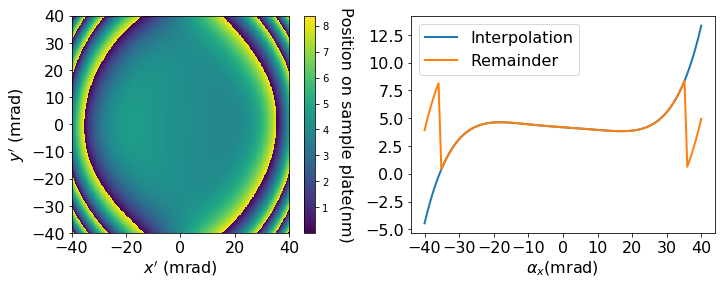

In [289]:
temp = np.array([[((xfunc(kx, ky)[0][0] + sampleL/2)%sampleL) for kx in kx_fine] for ky in ky_fine])
center = int(x_grid.shape[0]/2)

fig = plt.figure(figsize=[12,4])
plt.title('Position on phase plate')
plt.subplot(121)
plt.imshow(temp*1e9, extent = [-sigkx*maxsig*1000,sigkx*maxsig*1000,-sigky*maxsig*1000,sigky*maxsig*1000])
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_ylabel('Position on sample plate(nm)', rotation=270, fontsize=16)
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$", fontsize=16)
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(122)
plt.plot(kx_grid[center,:]*1000, (xfunc(kx_grid[center,:],0)+ sampleL/2)*1e9,label = 'Interpolation',linewidth=2)
plt.plot(kx_grid[center,:]*1000, (xfunc(kx_grid[center,:],0)+ sampleL/2)%sampleL*1e9, label='Remainder',linewidth=2)
plt.xlabel(r"$\alpha_x$(mrad)", fontsize=16)
# plt.ylabel(r"nm", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

## Check intial particle distribution and momentum

In [560]:
# Try new way to directly calculate emittance based on defination in unit of [pm*rad]
screen =  np.loadtxt(ASCIIFILE, skiprows=5)

x  = screen[:,0]
y  = screen[:,1]
x = x * 1e12
y = y * 1e12  # x and y in unit of pm

kx = MConHBAR*screen[:,4]*screen[:,7]
ky = MConHBAR*screen[:,5]*screen[:,7]
kz = MConHBAR*screen[:,6]*screen[:,7]
# ax = np.arctan(kx/kz) # x_angle in unit of radian
# ay = np.arctan(ky/kz) # y_angle in unit of radian
ax = np.divide(screen[:,4], screen[:,6])
ay = np.divide(screen[:,5], screen[:,6])


(-0.0005, 0.0005)

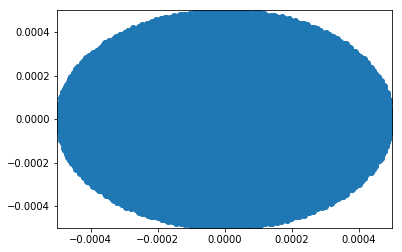

In [566]:
plt.scatter(ax,ay)
plt.xlim([-0.0005,0.0005])
plt.ylim([-0.0005,0.0005])